In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
dist_pickle = pickle.load( open( "camera_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [3]:
img=cv2.imread('camera_cal/calibration4.jpg')
nx=8
ny=6


In [4]:
def combineGradients(img):
    """
    Compute the combination of Sobel X and Sobel Y or Magnitude and Direction
    """
    sobelX = withSobelX(img)
    sobelY = withSobelY(img)
    combined = np.zeros_like(sobelX) 
    combined[((sobelX == 1) & (sobelY == 1))] = 1
    return combined

In [5]:
def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray=cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    M=None
    warped=img
    if ret==True:
        img = cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
        src = np.float32([corners[0],corners[nx - 1],corners[-1],corners[-nx]]) 
        dst=np.float32([[100,100],[gray.shape[1]-100,100],[gray.shape[1]-100,gray.shape[0]-100],[100,gray.shape[0]-100]])
        M = cv2.getPerspectiveTransform(src,dst)
        warped = cv2.warpPerspective(undist,M,(gray.shape[1],gray.shape[0]))
    return warped, M

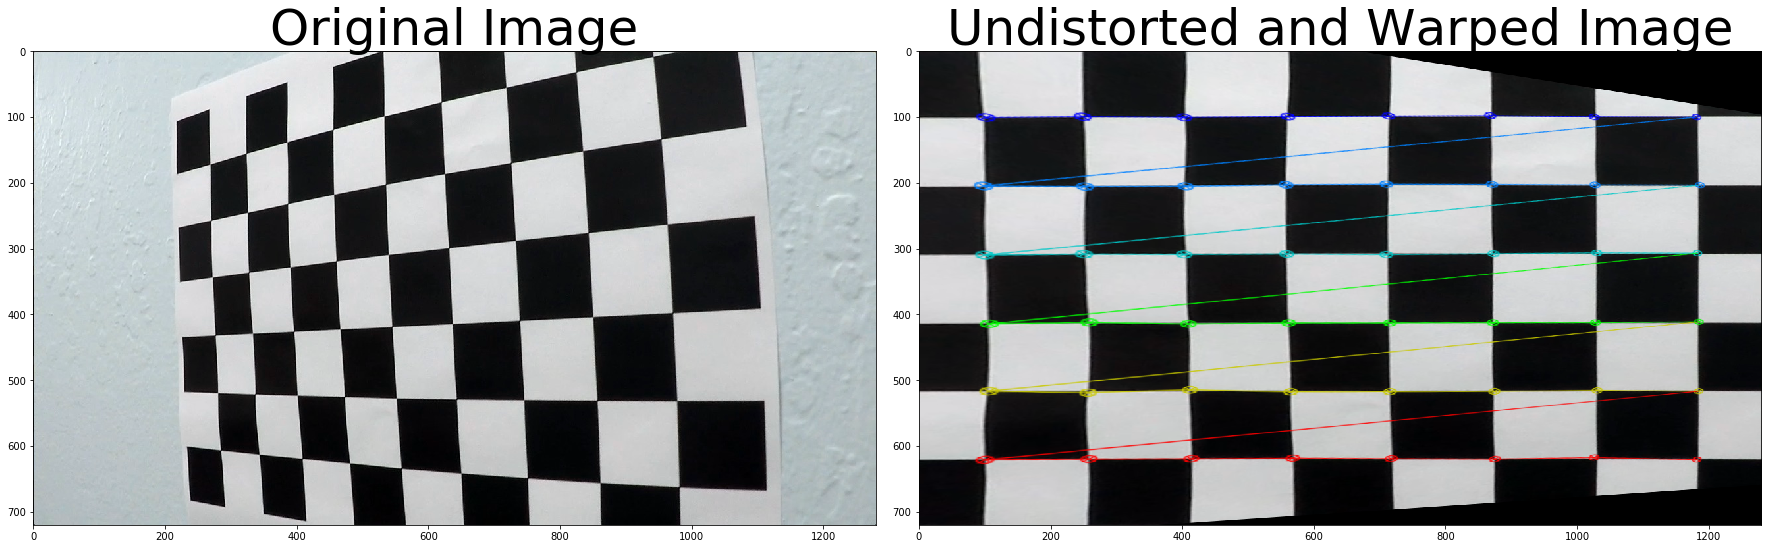

In [6]:
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


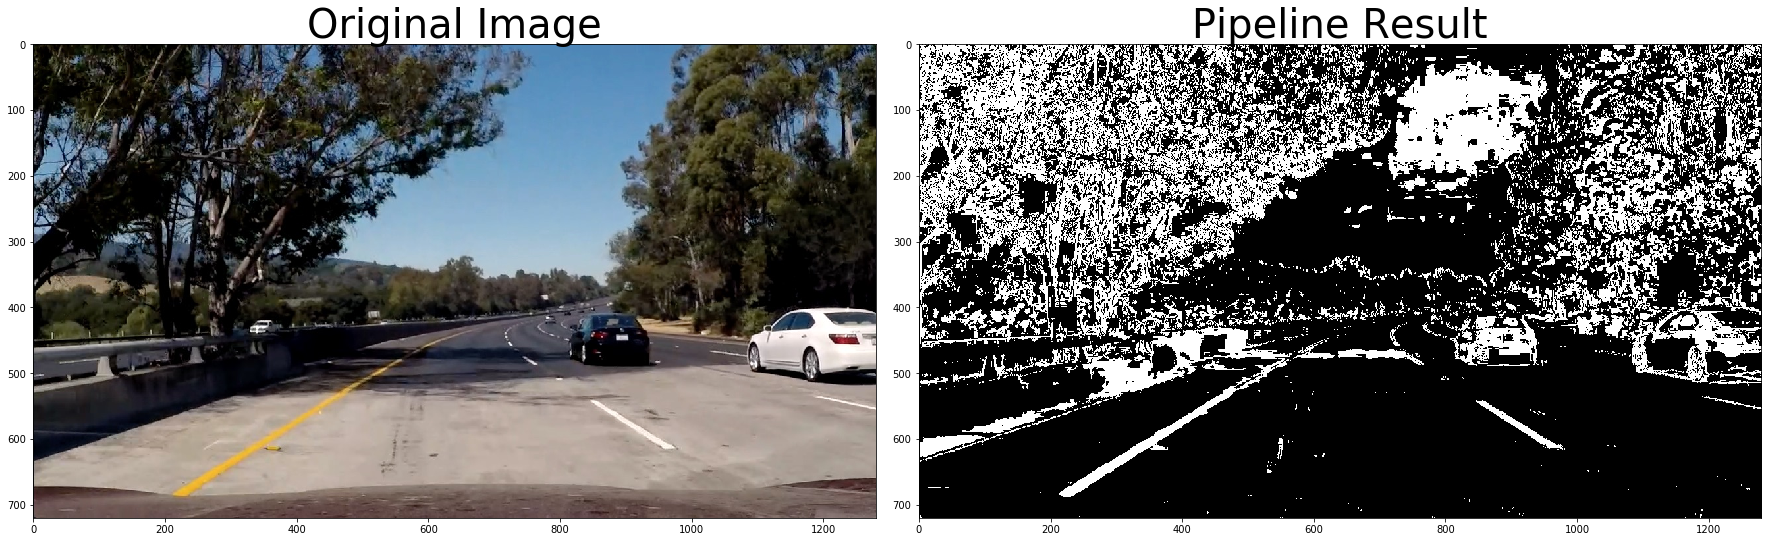

In [7]:
image=cv2.imread('test_images/test5.jpg')
def pipeline(img, s_thresh=(110, 255), sx_thresh=(20, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    binary=np.zeros_like(sxbinary)
    binary[((s_binary == 1) | (sxbinary==1))] = 1
    binary=255*np.dstack((binary,binary,binary))
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return binary
    
result = pipeline(image)
cv2.imwrite('output_images/binary_image.jpg',result)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def unwarp(img):
    corners = np.float32([[190,720],[530,490],[770,490],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[100,0]
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])
    M=cv2.getPerspectiveTransform(src, dst)
    Minv=cv2.getPerspectiveTransform(dst,src)
    warped=cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped,M,Minv

In [9]:
warped,M,Minv=unwarp(result)
cv2.imshow('a',warped)
cv2.waitKey()
cv2.destroyAllWindows()

In [10]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

Text(0.5,1,'Warped')

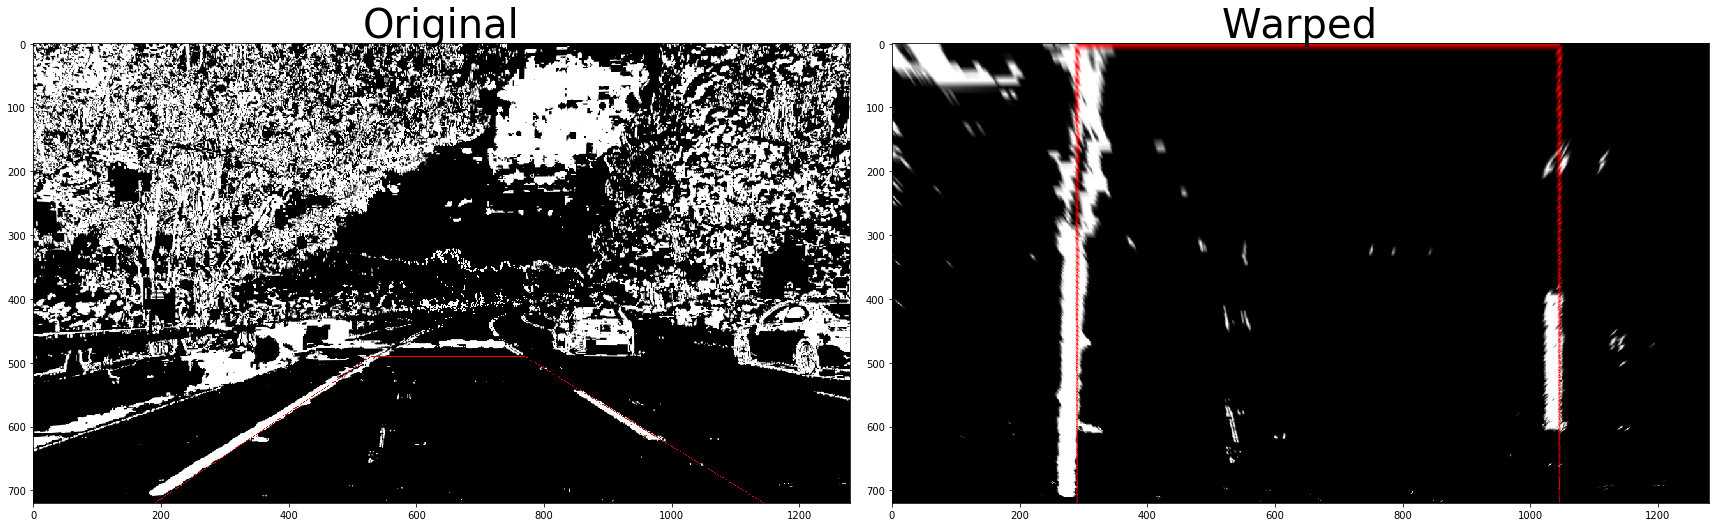

In [13]:
# img=plt.imread('test_images/straight_lines1.jpg')
img=np.copy(result)
corners = np.float32([[190,720],[530,490],[770,490],[1145,720]])
img = cv2.undistort(img, mtx, dist, None, mtx)
imshape = img.shape

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)

warped,M,Minv = unwarp(img) 

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Warped', fontsize=40)

In [14]:
def hist(img):
    bottom_half=img[img.shape[0]//2:,:]
    histogram=np.sum(bottom_half,axis=0)
    return histogram

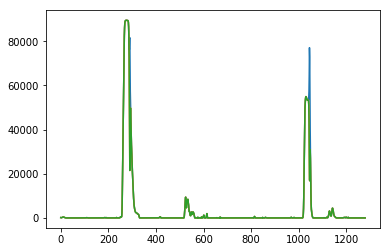

In [15]:
histogram=hist(warped)
plt.plot(histogram)

In [16]:
def find_lane_pixels(binary_warped):
    histogram=np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
    
    out_img=np.dstack((binary_warped,binary_warped,binary_warped))
    
    midpoint=np.int(histogram.shape[0]//2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:])+midpoint
    #number of sliding windows
    nwindows=9
    margin=100
    minpix=50
    window_height=np.int(binary_warped.shape[0]//nwindows)
    nonzero=binary_warped.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    
    leftx_current=leftx_base
    rightx_current=rightx_base
    
    left_lane_inds=[]
    right_lane_inds=[]
    
    for window in range(nwindows):
        win_y_low=binary_warped.shape[0]-(window+1)*window_height
        win_y_high=binary_warped.shape[0]-window*window_height
        
        win_xleft_low=leftx_current-margin
        win_xleft_high=leftx_current+margin
        win_xright_low=rightx_current-margin
        win_xright_high=rightx_current+margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    try:
        left_lane_inds=np.concatenate(left_lane_inds)
        right_lane_inds=np.concatenate(right_lane_inds)
        
    except ValueError:
        pass
    
    leftx=nonzerox[left_lane_inds]
    lefty=nonzeroy[left_lane_inds]
    rightx=nonzerox[right_lane_inds]
    righty=nonzeroy[right_lane_inds]
    
    return leftx,lefty,rightx,righty,out_img        
        
    

In [19]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return out_img,ploty,left_fit,right_fit,left_fitx,right_fitx

In [20]:
# warped=cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
out_img,ploty,left_fit,right_fit,left_fitx,right_fitx=fit_polynomial(warped)
plt.imshow(out_img)
print(np.max(ploty))

error: OpenCV(3.4.4) C:\projects\opencv-python\opencv\modules\core\src\array.cpp:3241: error: (-215:Assertion failed) cn <= 4 in function 'cv::scalarToRawData'


In [23]:
def curvature(ploty,fit_cr):
    ym_per_pix = 30/720
    return ((1+(2*fit_cr[0]*ploty*ym_per_pix+fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])


left_curvature=curvature(np.max(ploty),left_fit)
right_curvature=curvature(np.max(ploty),right_fit)
print(right_curvature,"m")

NameError: name 'ploty' is not defined

In [24]:
def draw(image,left_fit,right_fit):
    yMax = image.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(image).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(result)

In [25]:
def pipeline_(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    # Sobel Absolute (using default parameters)
    #img_sobelAbs = abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    #img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, Minv

In [26]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [29]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline_(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out

In [30]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

NameError: name 'src' is not defined